# Analyze neutralization data
This Python Jupyter notebook analyzes the neutralization data.

Import Python modules.
We use [neutcurve](https://jbloomlab.github.io/neutcurve/) to plot the neutralization curves:

In [1]:
import os
import re
import warnings

from IPython.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *
from statistics import geometric_mean
from scipy import stats

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Read config file

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Specify input / output files:

In [3]:
# output directory
results='results/neut_titers'
os.makedirs(results, exist_ok = True)

# input files
fracinfect_file = 'results/neut_titers/fracinfect.csv'

# output files
neut_titers_file = f'{results}/neut_titers.csv'
neut_titers_summary_file = f'{results}/neut_titers_summary.csv'
all_replicate_curves = f'{results}/all_replicate_curves.pdf'

## Read in the neutralization data

In [4]:
print(f"Reading neutralization data from {fracinfect_file}")
fracinfect = (pd.read_csv(fracinfect_file)
              .replace({'virus': config['virus_key_mutneuts']})
             )

# order the viruses
virus_order = config['virus_order']

fracinfect = (
    fracinfect
    .assign(replicate_with_date=lambda x: x['replicate'].astype(str) +
                                          ' (' + x['date'] + ')')
    .query('virus in @virus_order')
    .assign(virus=lambda x: pd.Categorical(x['virus'], virus_order, ordered=True))
    .rename(columns={'replicate': 'replicate_on_date'})
)
fracinfect = (
    fracinfect
    .merge(fracinfect
           .sort_values('date')
           [['serum', 'virus', 'replicate_with_date']]
           .drop_duplicates()
           .assign(replicate_all_dates=lambda x: x.groupby(['serum', 'virus'])
                                                  ['replicate_with_date']
                                                  .transform('cumcount') + 1
                   ),
            how='left', on=['serum', 'virus', 'replicate_with_date'], validate='many_to_one',
            )
    )

# show first few lines of data frame
display(HTML(fracinfect.head().to_html(index=False)))

Reading neutralization data from results/neut_titers/fracinfect.csv


serum,virus,replicate_on_date,concentration,fraction infectivity,date,replicate_with_date,replicate_all_dates
Delta_10,D614G,1,0.040000,0.000008,2022-01-06,1 (2022-01-06),4
Delta_10,D614G,1,0.010000,0.004703,2022-01-06,1 (2022-01-06),4
Delta_10,D614G,1,0.002500,0.228100,2022-01-06,1 (2022-01-06),4
Delta_10,D614G,1,0.000625,0.823500,2022-01-06,1 (2022-01-06),4
Delta_10,D614G,1,0.000156,0.961300,2022-01-06,1 (2022-01-06),4


In [5]:
fits = neutcurve.curvefits.CurveFits(
            data=fracinfect,
            replicate_col='replicate_all_dates',
            )

Plot all replicate curves for each `serum x virus` condition.
However, note that this is *really slow* when there are a lot of curves to plot! 

Saving plot to results/neut_titers/all_replicate_curves.pdf



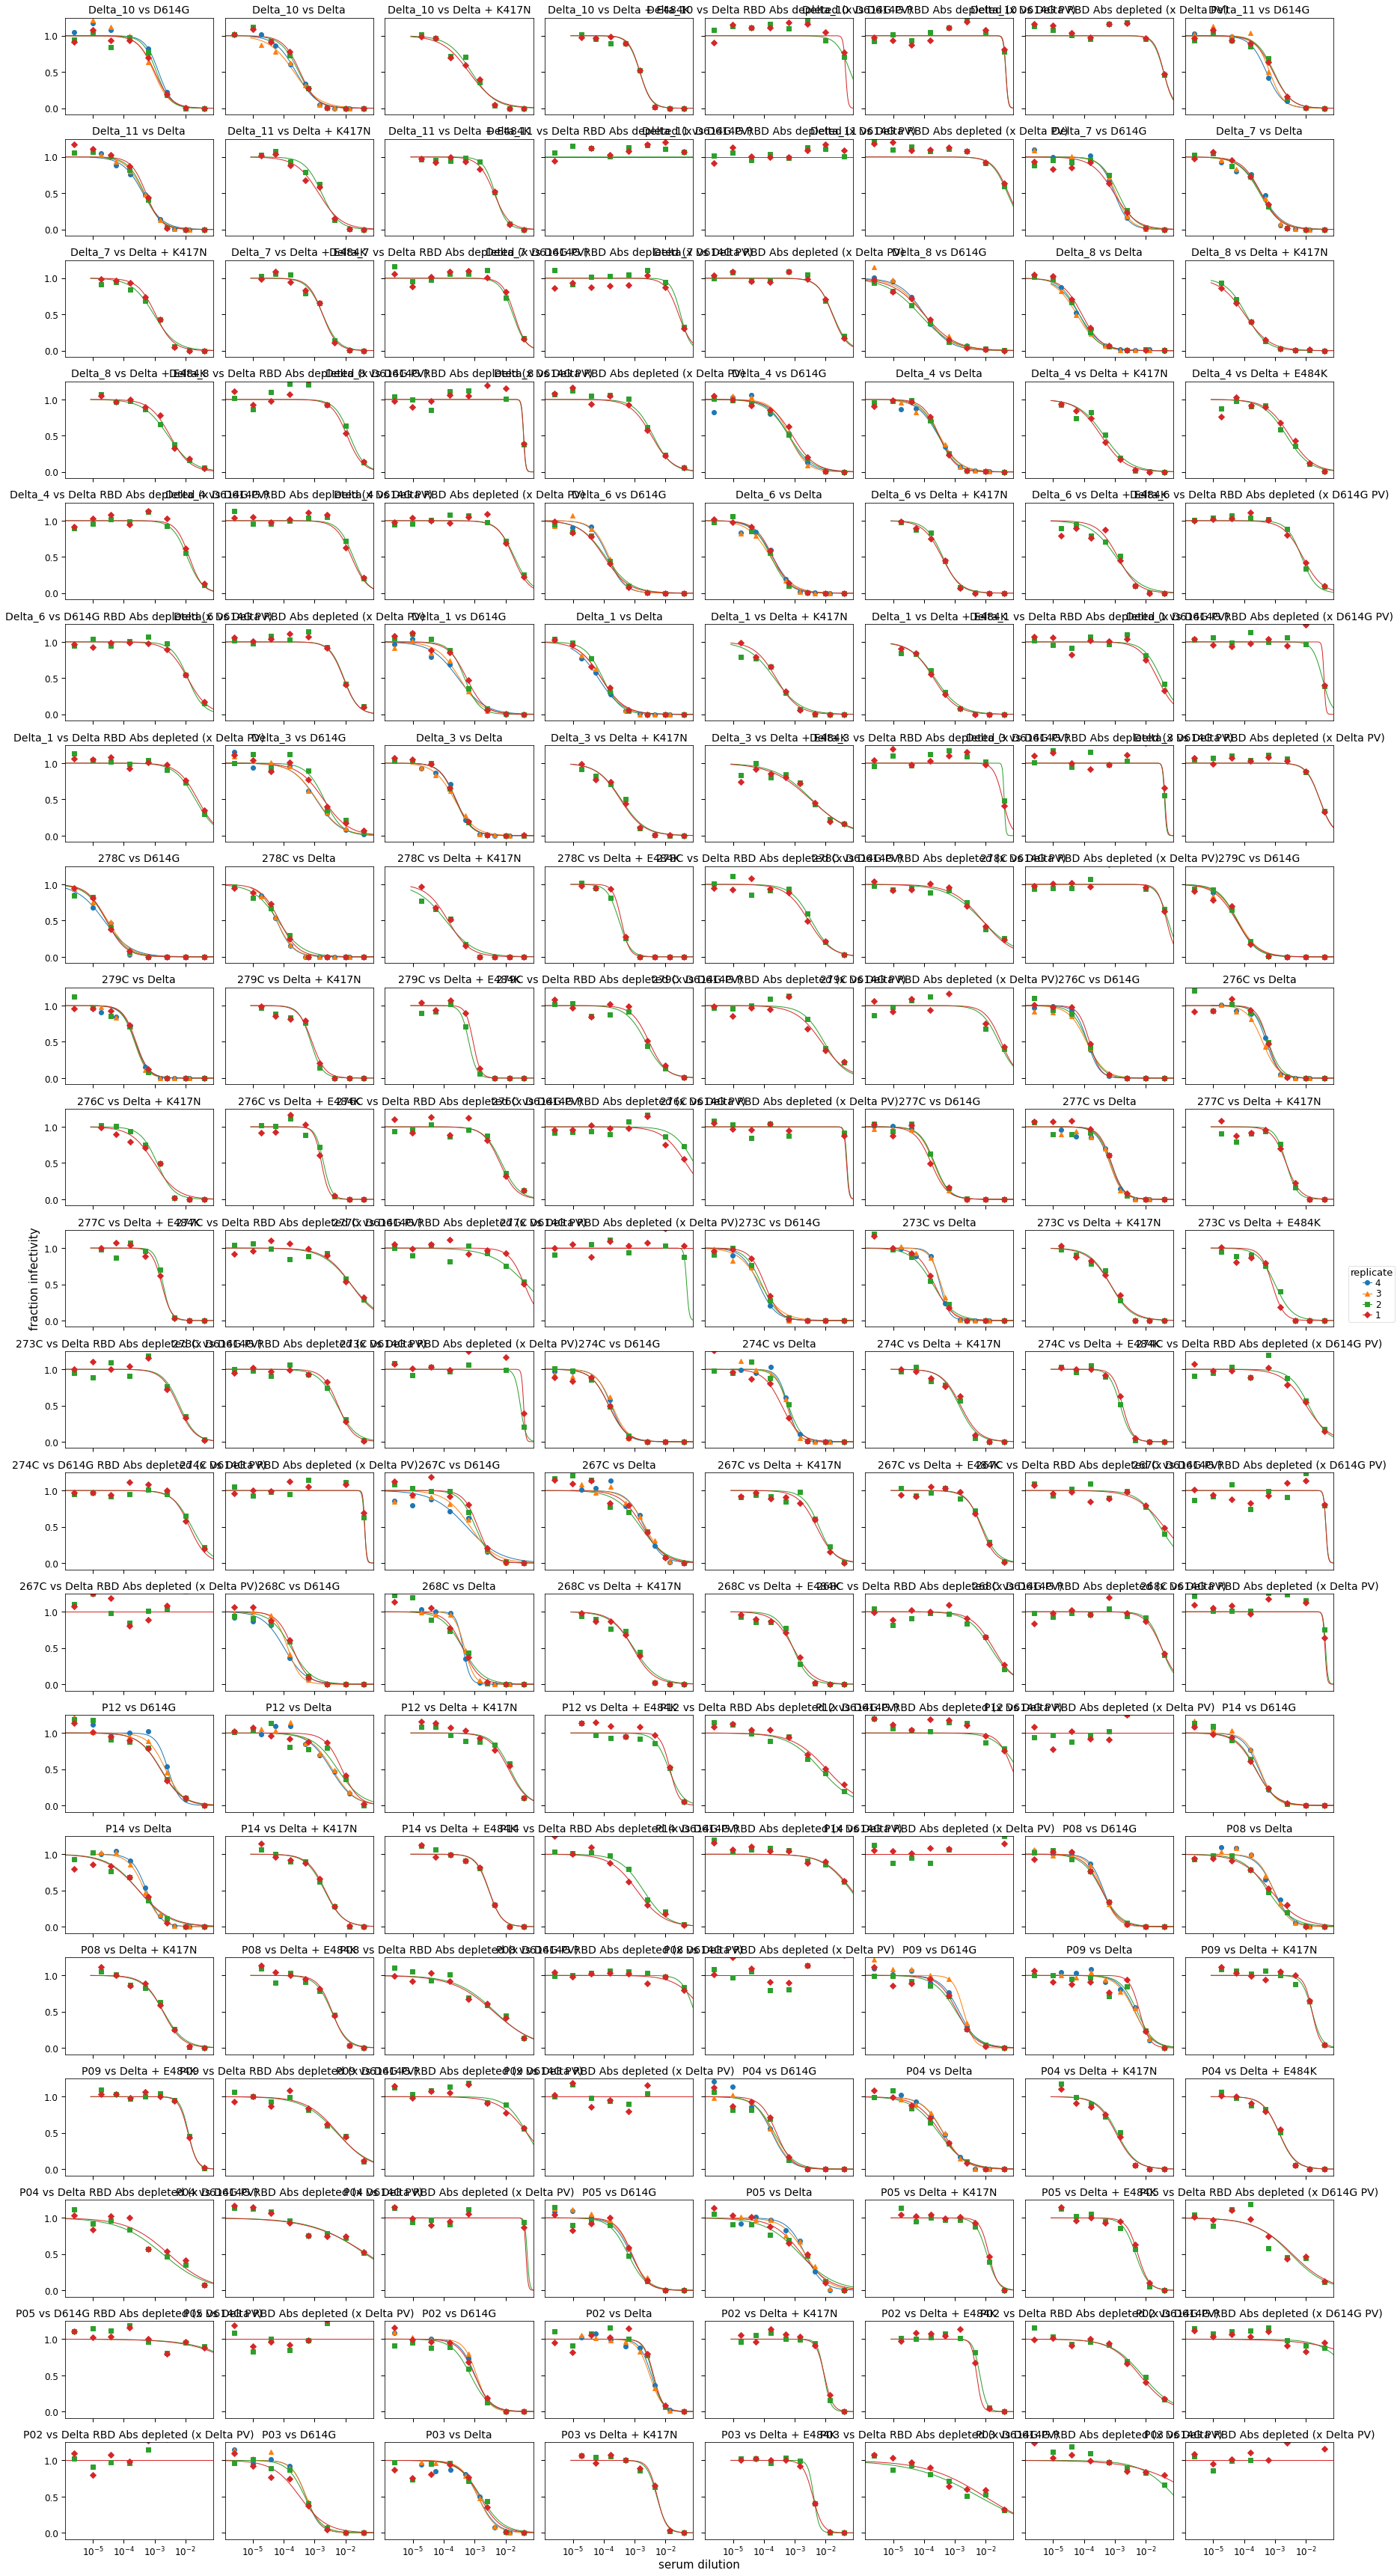

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ignore fitting warnings
    fig, _ = fits.plotReplicates(ncol=8,
                                 legendtitle='replicate',
                                 xlabel='serum dilution',
                                 viruses=fracinfect['virus'].sort_values().unique(),
                                 colors=plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2,
                                 markers=['o', '^', 's', 'D', 'v', '<', '>', 'p'] * 2,
                                 fix_lims={'ymax':1.25},
                                 )
    
print(f"Saving plot to {all_replicate_curves}\n")
fig.savefig(all_replicate_curves)
fig.tight_layout()
display(fig)
plt.close(fig)

Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit neutralization curves to all of the data:

In [7]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in fracinfect['date'].unique():
    fits = neutcurve.CurveFits(fracinfect.query('date==@d'),
                               replicate_col='replicate_on_date',
                              )

    fp = (
        fits.fitParams(average_only=False)
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        # .replace({'WT':'wildtype', 'B.1.351':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date', 'replicate', 'top']] 
        .assign(ic50_is_bound=lambda x: x['ic50_bound'].map({'lower': True,
                                                          'interpolated': False}))
        )
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated


,serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound
0,Delta_10,D614G,0.001349,741.511063,interpolated,2022-01-06,1,1.0,False
1,Delta_10,D614G,0.000942,1061.588219,interpolated,2022-01-06,2,1.0,False
2,Delta_10,D614G,0.001134,882.157389,interpolated,2022-01-06,average,1.0,False
3,Delta_10,Delta RBD Abs depleted (x D614G PV),0.040000,25.000000,lower,2022-01-06,1,1.0,True
4,Delta_10,Delta RBD Abs depleted (x D614G PV),0.040000,25.000000,lower,2022-01-06,2,1.0,True


Make a plot showing all viruses against each sera from each assay date:

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated


Saving to results/neut_titers/2022-01-06_mutant_neuts.pdf
Saving to results/neut_titers/2021-11-25_mutant_neuts.pdf
Saving to results/neut_titers/2021-12-19_mutant_neuts.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt


Saving to results/neut_titers/2021-12-22_mutant_neuts.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated


Saving to results/neut_titers/2021-11-12_mutant_neuts.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power


Saving to results/neut_titers/2021-12-12_mutant_neuts.pdf


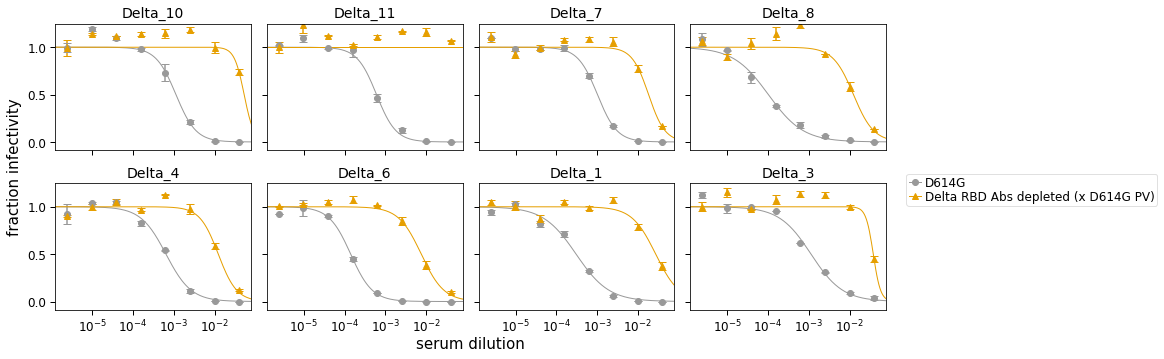

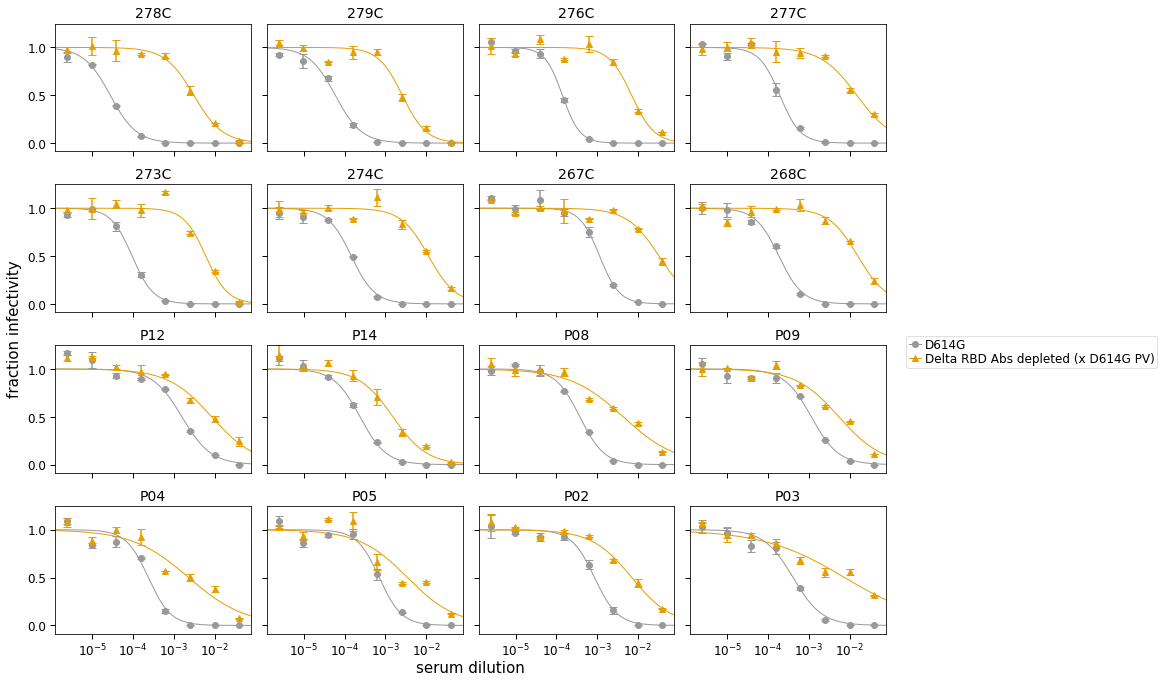

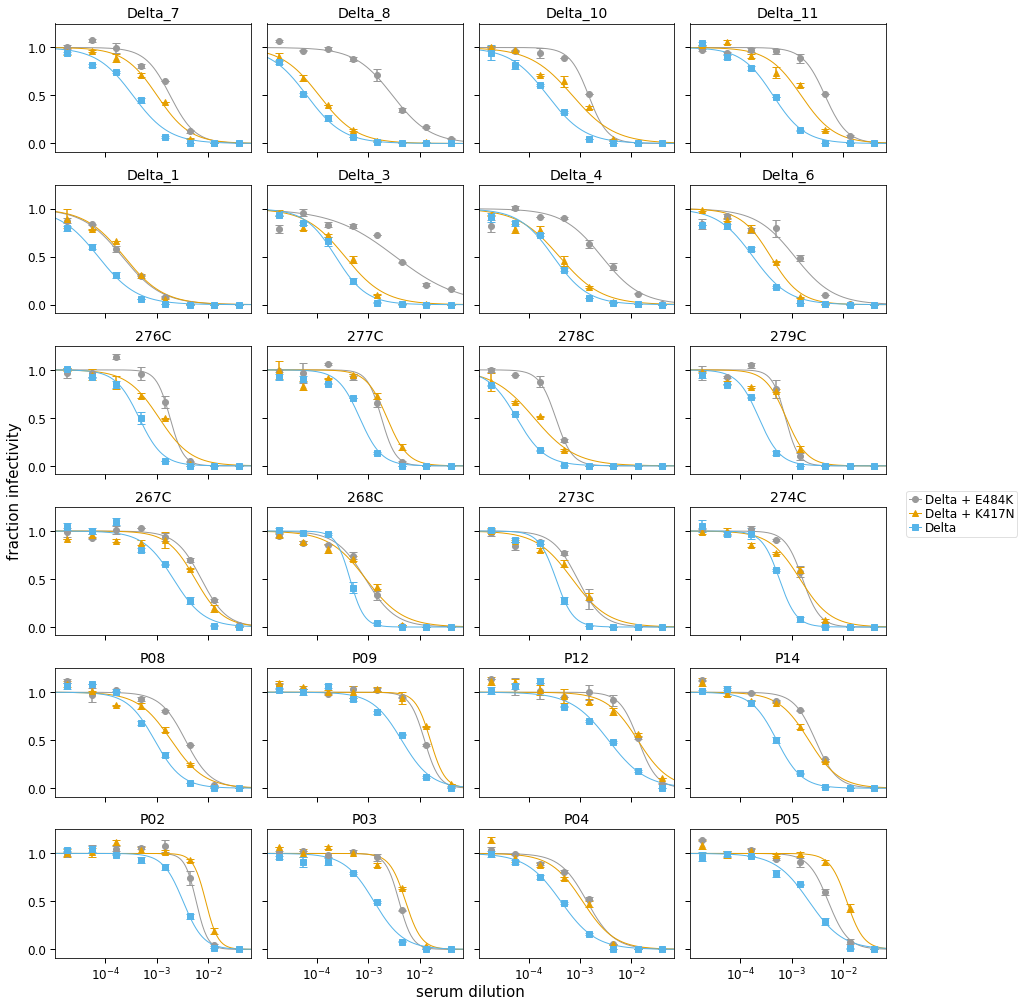

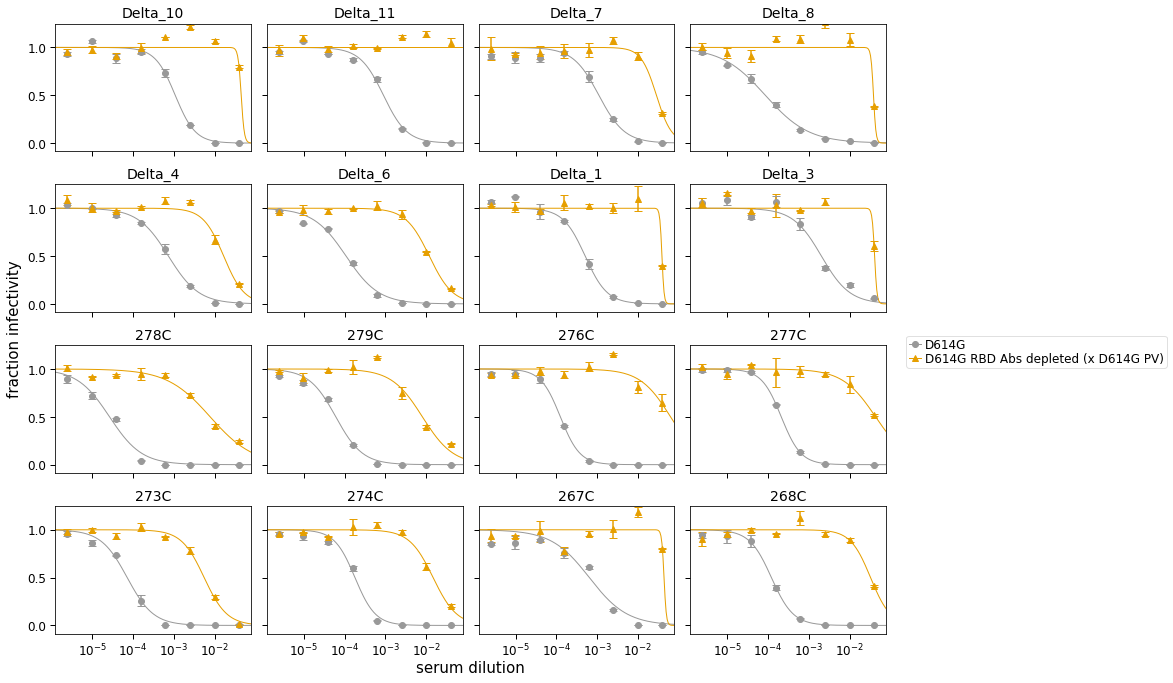

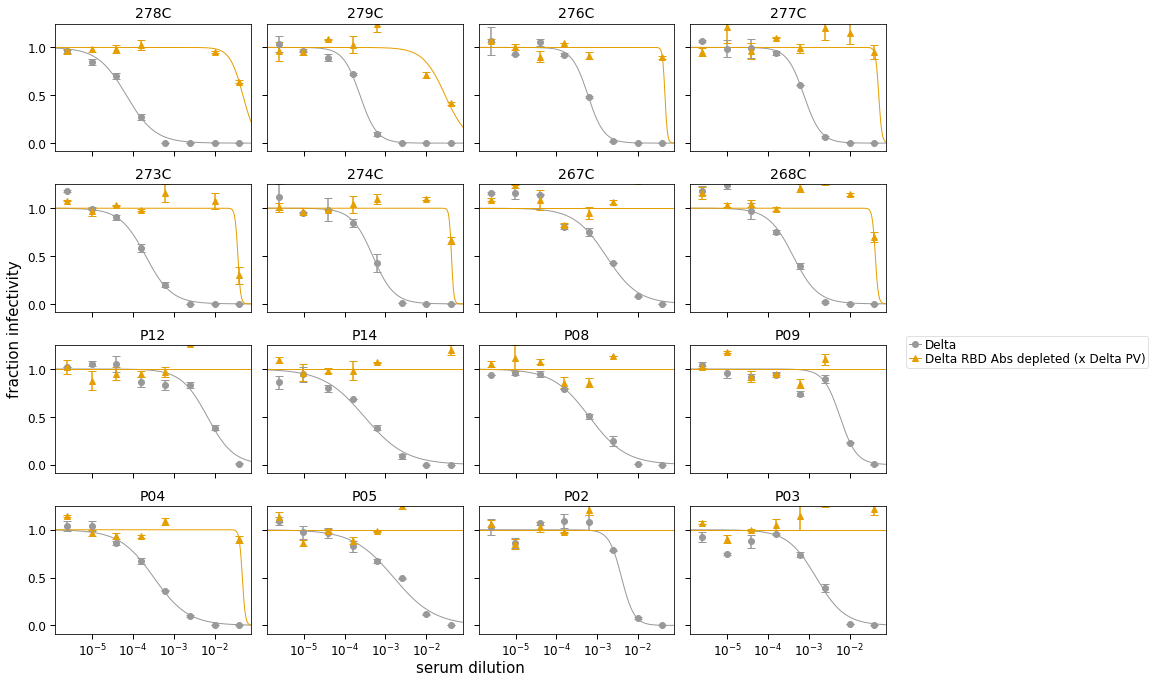

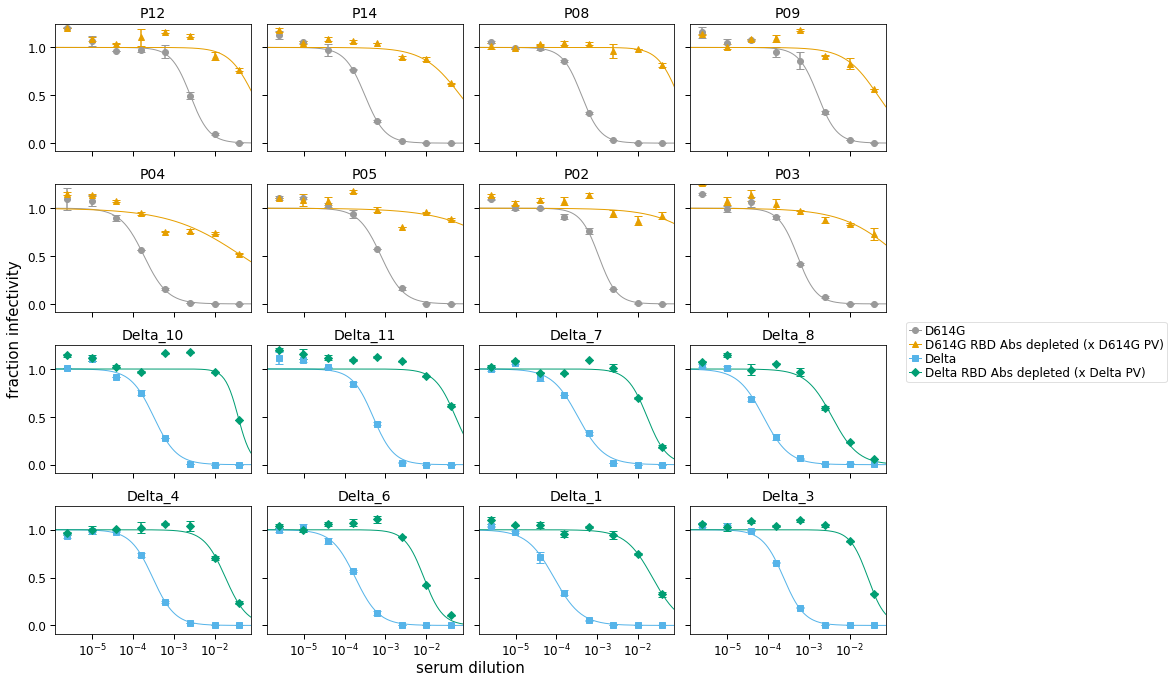

In [8]:
for d in fracinfect['date'].unique():
    fits = (neutcurve.CurveFits(fracinfect.query('date==@d'), 
                                replicate_col='replicate_on_date'
                               )
           )
    xlab= 'serum dilution'
    name= 'sera'

    fig, axes = fits.plotSera(xlabel=xlab,
                              # max_viruses_per_subplot=4,
                              colors=CBPALETTE*3, 
                              markers=CBMARKERS*3,
                              attempt_shared_legend=True,
                              fix_lims={'ymax':1.25}
                             )

    plotfile = f'{results}/{d}_mutant_neuts.pdf'
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')

### Plot all neuts for each serum on the same axis

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:451: RuntimeWarning: invalid value encountered in sqrt
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated


Saving to results/neut_titers/all_mutant_neuts.pdf


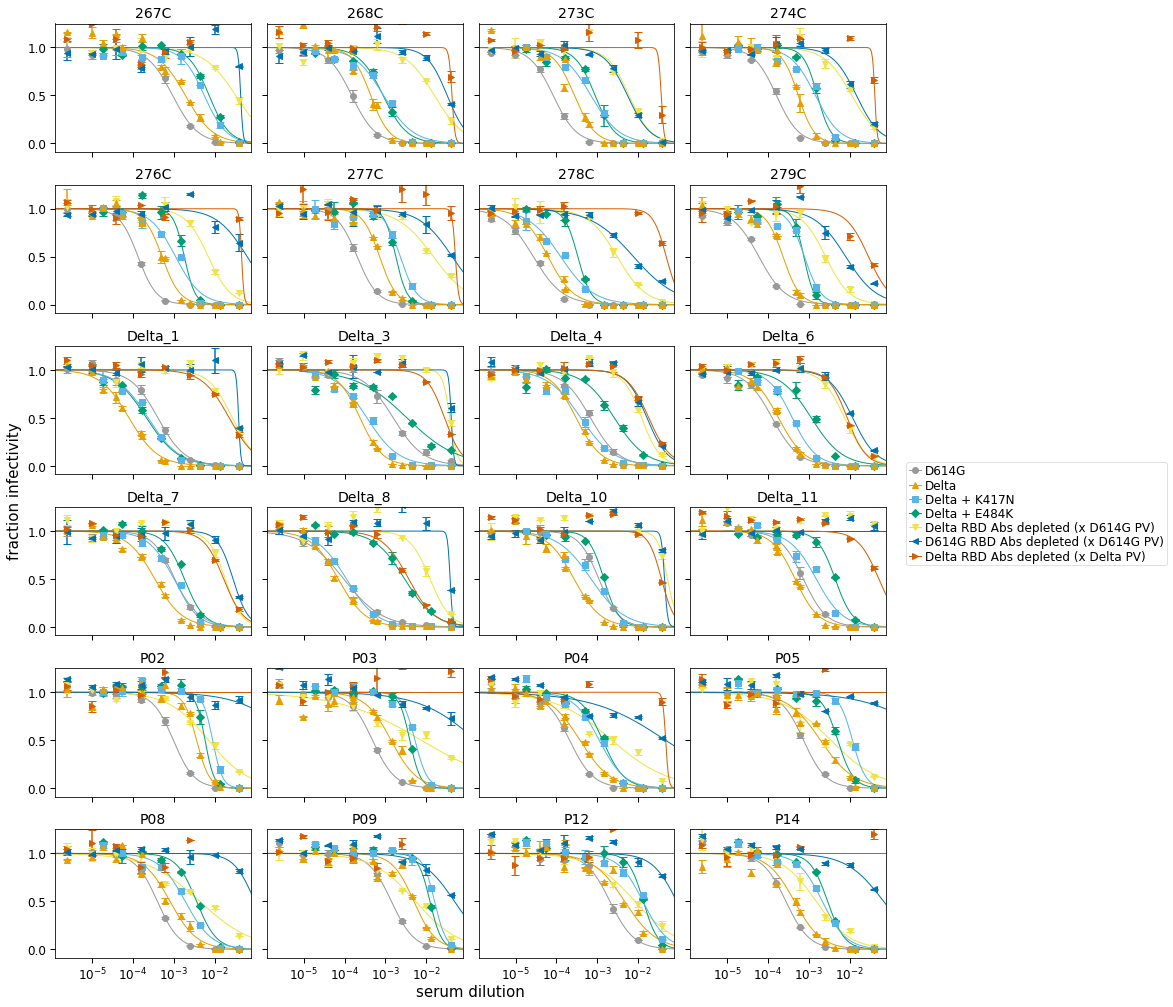

In [9]:
fits = (neutcurve.CurveFits(fracinfect, 
                            replicate_col='replicate_all_dates'
                           )
       )
xlab= 'serum dilution'
name= 'sera'

fig, axes = fits.plotSera(xlabel=xlab,
                          max_viruses_per_subplot=8,
                          colors=CBPALETTE*3, 
                          markers=CBMARKERS*3,
                          attempt_shared_legend=True,
                          fix_lims={'ymax':1.25},
                          viruses=config['virus_order'],
                          sera=natsort.natsorted(fracinfect['serum'].unique()),
                         )

plotfile = f'{results}/all_mutant_neuts.pdf'
print(f"Saving to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

### Calculate fold-change IC50 relative to the geometric mean of the wildtype virus against each serum on each date
* Get neutralization titers, 
* Drop "average" replicate
* Calculate the geometric mean of the wildtype virus against each serum
* Calculate fold-change IC50

No longer subset on date, because Delta virus wasn't run on D614G experiment days

In [10]:
wildtype = config['wildtype_virus']

neut_titers = (
    fitparams
    .merge((fitparams
            .query('virus == @wildtype & replicate != "average"')
            .groupby(['serum'])
            
            # get the geometric mean of the two wildtype replicates 
            .agg(wildtype_ic50=pd.NamedAgg(column="ic50", aggfunc=geometric_mean))
            .reset_index()
           ),
           on=['serum'],
           how='left',
           validate='many_to_one',
           )
    .merge((pd.read_csv(config['sample_key_file'])
            [['subject_name', 'sample_type']]
            .rename(columns={'subject_name':'serum'})
           ),
           on='serum',
           how='left',
           validate='many_to_one',
          )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            sample_type=lambda x: pd.Categorical(x['sample_type'], ordered=True, categories=config['sample_type_order'])
           )
    )


display(HTML(neut_titers.head().to_html(index=False)))
neut_titers.to_csv(neut_titers_file, index=False)

serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,sample_type,fold_change
Delta_10,D614G,0.001349,741.511063,interpolated,2022-01-06,1,1.0,False,0.000273,primary Delta infection,4.938653
Delta_10,D614G,0.000942,1061.588219,interpolated,2022-01-06,2,1.0,False,0.000273,primary Delta infection,3.449611
Delta_10,D614G,0.001134,882.157389,interpolated,2022-01-06,average,1.0,False,0.000273,primary Delta infection,4.151261
Delta_10,Delta RBD Abs depleted (x D614G PV),0.040000,25.000000,lower,2022-01-06,1,1.0,True,0.000273,primary Delta infection,146.482637
Delta_10,Delta RBD Abs depleted (x D614G PV),0.040000,25.000000,lower,2022-01-06,2,1.0,True,0.000273,primary Delta infection,146.482637


As we can see below, the fold-change in IC50 for each wildtype replicate is no longer exactly 1 (because we are comparing to the geometric mean of the replicate measurements). Here I am pulling out the most extreme fold_change IC50s for wildtype (relative to the geometric mean):

In [11]:
display(HTML(neut_titers.query('virus==@wildtype & replicate != "average" & (fold_change <0.8 | fold_change >1.2)').head(2).to_html(index=False)))

serum,virus,ic50,NT50,ic50_bound,date,replicate,top,ic50_is_bound,wildtype_ic50,sample_type,fold_change
Delta_10,Delta,0.000216,4631.420274,interpolated,2021-12-19,1,1.0,False,0.000273,primary Delta infection,0.790700
276C,Delta,0.000398,2514.655718,interpolated,2021-12-19,2,1.0,False,0.000522,Delta breakthrough,0.762389


### Plot the fold-change IC50 relative to wildtype.
We will also plot each wild type replicate (as each deviates slightly from 1).  

Plot IC50 and fold-change IC50 for each serum x virus

Making plot for fold_change for mutneuts:
Saving to results/neut_titers/fold_change_mutneuts.pdf
Making plot for ic50 for mutneuts:
Saving to results/neut_titers/ic50_mutneuts.pdf


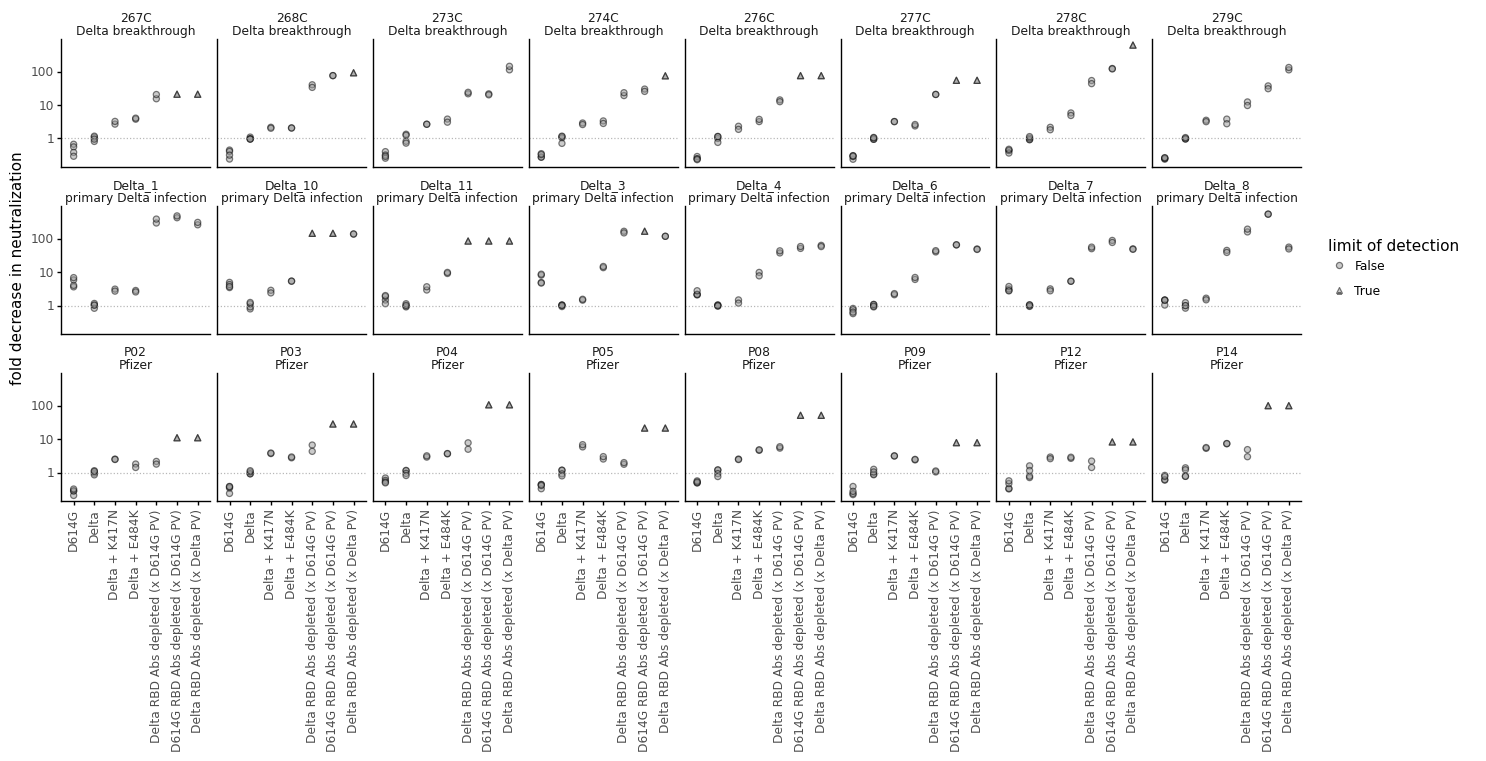

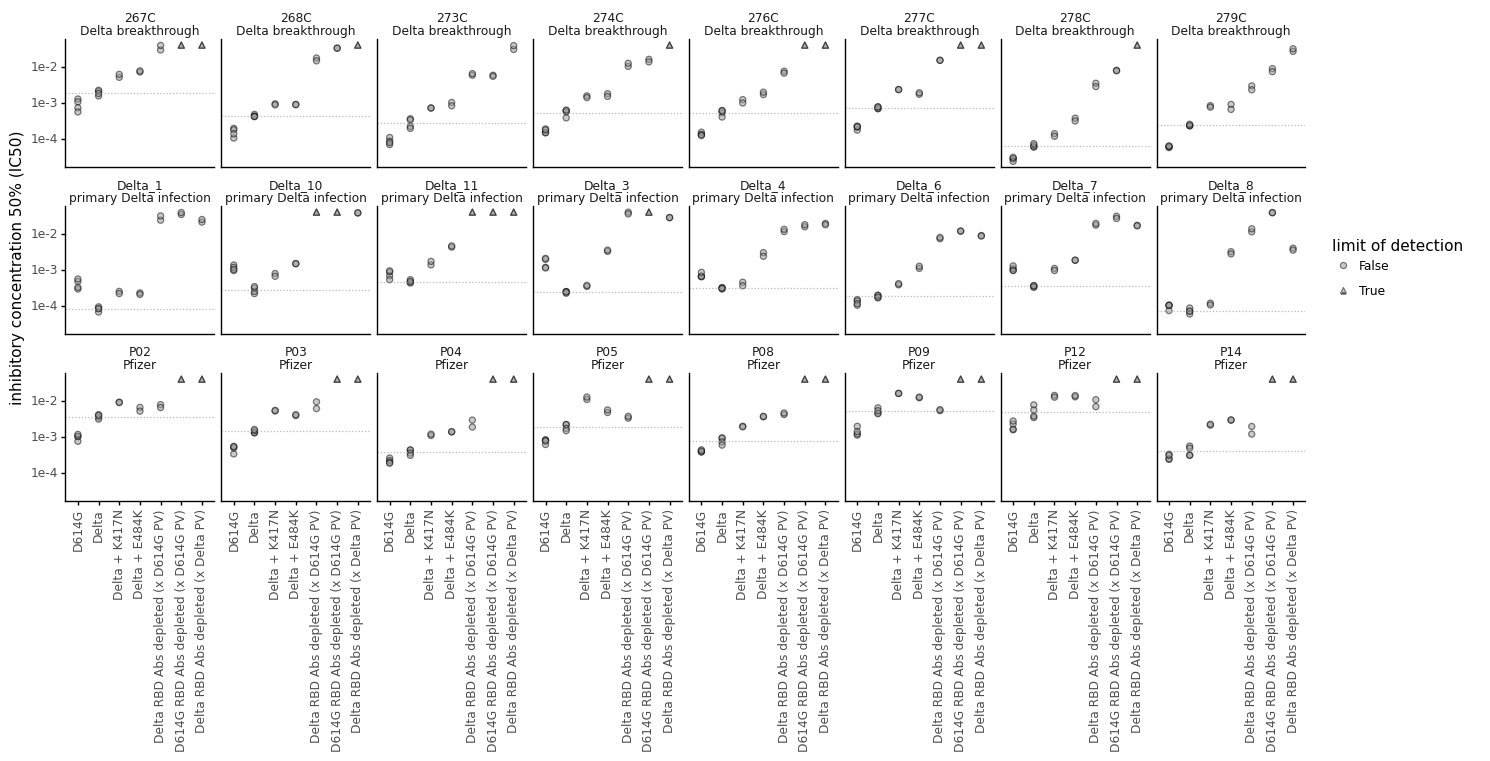

In [12]:
for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 'ic50':'inhibitory concentration 50% (IC50)'}

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & replicate!= 'average'") # & date in @dates
                    .assign(virus=lambda x: pd.Categorical(x['virus'],
                                                              ordered=True,
                                                              categories=virus_subsample)
                           )
                    ) +
             aes('virus', metric, shape='ic50_is_bound',
                ) +
             geom_point(size=2, alpha=0.5, fill='#999999',) +  
             scale_y_log10(name=ylab[metric]) +
             facet_wrap('~serum+sample_type', ncol=8, ) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
               axis_title_x=element_blank(),
               strip_background_x=element_blank(),
               figure_size=(16, 6),
               ) +
             geom_hline(data=(neut_titers
                              .query('virus in [@wildtype, "RBD antibodies depleted (Delta)"] & replicate!="average" ') #& date in @dates
                              .groupby(['serum', 'virus', 'sample_type'])
                              .agg({metric: geometric_mean})
                              .reset_index()
                              .dropna()
                             ),
                        inherit_aes=False,
                        mapping=aes(yintercept=metric, color='virus'),
                        alpha=0.7,
                        size=0.5,
                        linetype='dotted',
                       ) +
             scale_shape_manual(values=['o','^'], name='limit of detection') +
             scale_color_manual(values=CBPALETTE*3, guide=False) 
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

### Plot the NT50 and fold-change IC50 for all individuals, faceting by cohort.

Add the geometric mean of all for each cohort as well. 

Making plot for fold_change for mutneuts:
(0.22977515116553654, 695.9233012585322)
Saving to results/neut_titers/fold_change_mutneuts_aggregate_simple.pdf
Making plot for NT50 for mutneuts:
(22.499999999999996, 40495.49949040342)
Saving to results/neut_titers/NT50_mutneuts_aggregate_simple.pdf


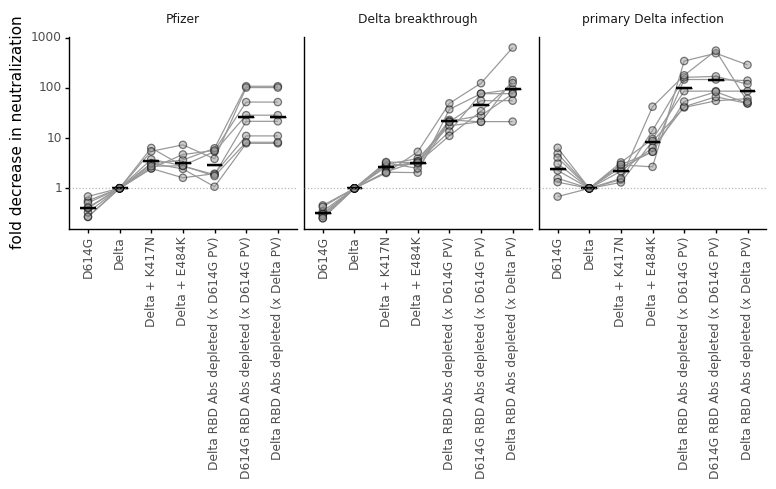

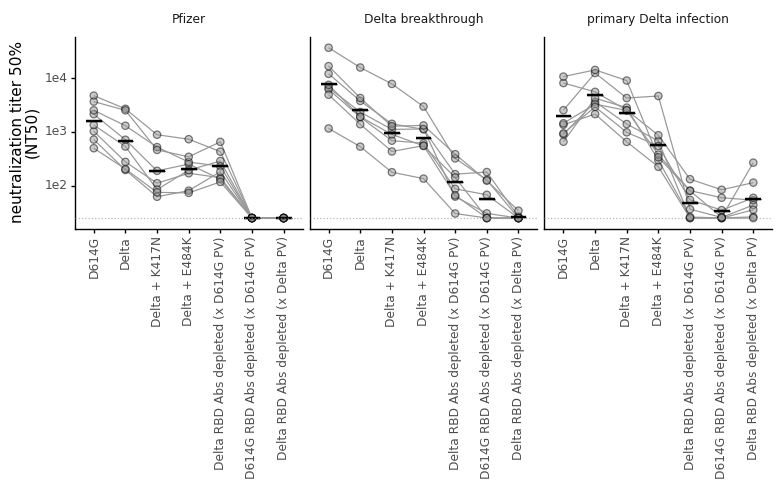

In [13]:
for metric in ['fold_change', 'NT50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        ylab={'fold_change':'fold decrease in neutralization', 
              'NT50':'neutralization titer 50%\n(NT50)'
             }
        
        yintercept={'fold_change':1,
                    'NT50': config['NT50_LOD']
                   }
        
        # define df to do plotting on:
        df=(neut_titers
            .query("virus in @virus_subsample & replicate== 'average'")
            .assign(virus=lambda x: pd.Categorical(x['virus'],
                                                       ordered=True,
                                                       categories=virus_subsample))
            .groupby(['serum', 'virus', 'sample_type'])
            .agg({metric: geometric_mean})
            .reset_index()
            .dropna()
           )
        
        # define the y-axis limits so I can make them exactly the same between plots
        limits=(df[metric].min()*0.9, df[metric].max()*1.1)
        print(limits)

        p = (ggplot(df) +
             aes('virus', metric, group='serum') +
             geom_line(aes(x='virus', y=metric, group='serum'), color=CBPALETTE[0]) +
             geom_point(size=2.5, alpha=0.5, fill=CBPALETTE[0]) + 
             geom_crossbar(data=(df
                                 .groupby(['virus', 'sample_type'])
                                 .agg({metric: geometric_mean})
                                 .reset_index()
                                 .dropna()
                                ),
                           inherit_aes=False,
                           mapping=aes(x='virus', y=metric, ymin=metric, ymax=metric),
                          ) +
             scale_y_log10(name=ylab[metric], limits=limits) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   axis_title_x=element_blank(),
                   strip_margin_y=0.35,
                   strip_background_x=element_blank(),
                   figure_size=(3*neut_titers['sample_type'].nunique(), 2.5),
                   ) +
             geom_hline(yintercept=yintercept[metric],
                        alpha=0.7,
                        size=0.5,
                        linetype='dotted',
                        color=CBPALETTE[0]
                       ) +
             scale_color_manual(values=CBPALETTE*3, guide=False) +
             facet_wrap('~sample_type', scales='free_x')
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}_aggregate_simple.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

Make plot to show NT50 by cohort. 

(22.499999999999996, 40495.49949040342)


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


Saving to results/neut_titers/NT50_mutneuts_aggregate_nofacet.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


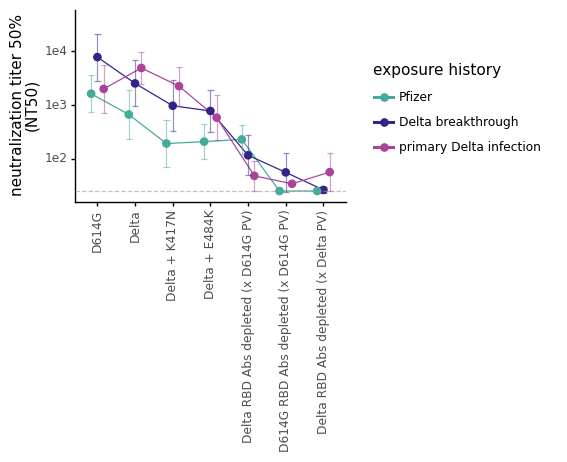

In [14]:
for virus_set, virus_subsample in config['virus_subsets'].items():
    
    # define df to do plotting on:
    df=(neut_titers
        .query("virus in @virus_subsample & replicate== 'average'")
        .assign(virus=lambda x: pd.Categorical(x['virus'],
                                                   ordered=True,
                                                   categories=virus_subsample))
        .groupby(['serum', 'virus', 'sample_type'])
        .agg({'NT50': geometric_mean})
        .reset_index()
        .dropna()
       )

    # define the y-axis limits so I can make them exactly the same between plots
    limits=(df['NT50'].min()*0.9, df['NT50'].max()*1.1)
    print(limits)

    p = (ggplot(df
                .groupby(['virus', 'sample_type'])
                .agg(NT50=('NT50', geometric_mean), sem=('NT50', stats.gstd))
                .reset_index()
                .dropna()
                ) +
         aes('virus', 
             'NT50', 
             fill='sample_type', 
             color='sample_type',
            ) +
         geom_line(aes(x='virus', y='NT50', group='sample_type'), position=position_dodge(width=0.5)) +
         geom_point(size=2.5, alpha=1, position=position_dodge(width=0.5)) +
         geom_errorbar(aes(x="virus", ymin="NT50/sem",ymax="NT50*sem"),
                       alpha=0.5,
                       position=position_dodge(width=0.5)
                      )+
         geom_hline(yintercept=config['NT50_LOD'],
                    linetype='dashed', size=0.5,
                    alpha=0.6, 
                    color=CBPALETTE[0]) +
         scale_y_log10(name='neutralization titer 50%\n(NT50)', limits=limits) +
         theme_classic() +
         theme(axis_title_x=element_blank(),
               figure_size=(neut_titers.query('virus in @virus_subsample')['virus'].nunique()*0.5, 2.5),
               axis_text_x=element_text(rotation=90)
               ) +
         scale_fill_manual(values=['#44AA99', '#332288', '#AA4499'], name='exposure history\n')+
         scale_color_manual(values=['#44AA99', '#332288', '#AA4499'], name='exposure history\n')
         )

    _ = p.draw()

    plotfile = f'{results}/NT50_{virus_set}_aggregate_nofacet.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, limitsize=False, verbose=False)

Make essentially the plot shown above, but with each individual point shown. 

Making plot for fold_change for mutneuts:
Making plot for 6 viruses
Saving to results/neut_titers/fold_change_mutneuts_aggregate_nofacet.pdf
Making plot for ic50 for mutneuts:
Making plot for 7 viruses
Saving to results/neut_titers/ic50_mutneuts_aggregate_nofacet.pdf


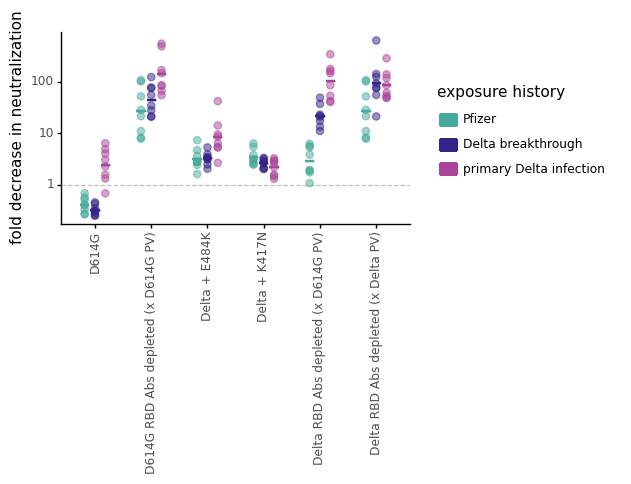

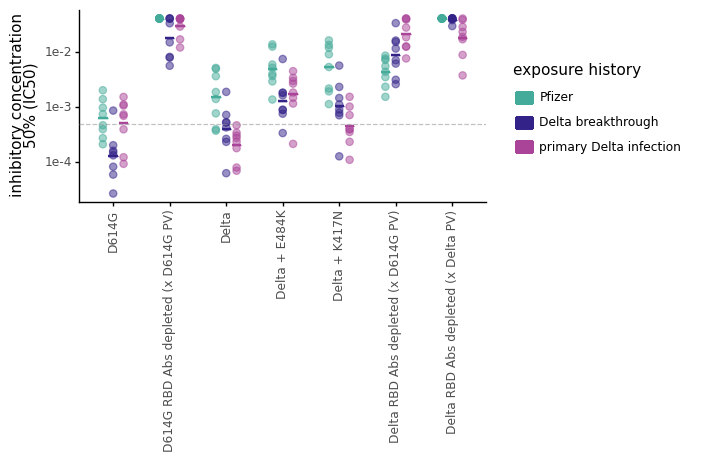

In [15]:
for metric in ['fold_change', 'ic50']:
    for virus_set, virus_subsample in config['virus_subsets'].items():
        print(f'Making plot for {metric} for {virus_set}:')
        
        if metric=="fold_change":
            virus_subsample=[v for v in virus_subsample if v!=wildtype]
        
        print(f"Making plot for {neut_titers.query('virus in @virus_subsample')['virus'].nunique()} viruses")
        
        ylab={'fold_change':'fold decrease in neutralization', 
              'ic50':'inhibitory concentration\n50% (IC50)'
             }
        yintercept={'fold_change':1, 
                    'ic50':(neut_titers
                            .query('virus==@wildtype')
                            ['ic50']
                            .agg(geometric_mean)
                           )
                   }

        p = (ggplot(neut_titers
                    .query("virus in @virus_subsample & replicate=='average'")
                    .assign(virus_labels=lambda x: pd.Categorical(x['virus'],
                                                                  ordered=True,
                                                                  categories=virus_subsample),
                           )
                    .groupby(['serum', 'virus', 'sample_type','ic50_is_bound'])
                    .agg({metric: geometric_mean})
                    .reset_index()
                    .dropna()
                    ) +
             aes('virus', 
                 metric, 
                 fill='sample_type', 
                 color='sample_type',
                 # shape='ic50_is_bound', 
                ) +
             # geom_line(aes(x='virus', y=metric, group='serum'),position=position_dodge(width=0.55),) +
             geom_point(position=position_dodge(width=0.55), size=2.5, alpha=0.5) +
             geom_crossbar(data=(neut_titers
                                 .query("virus in @virus_subsample & replicate=='average'")
                                 .groupby(['virus', 'sample_type'])
                                 .agg({metric: geometric_mean})
                                 .reset_index()
                                 .dropna()
                                ),
                           # inherit_aes=False,
                           mapping=aes(x='virus', y=metric, ymin=metric, ymax=metric,), #fill='sample_type', color='sample_type',
                           position=position_dodge(width=0.55),
                  ) +
             geom_hline(yintercept=yintercept[metric],
                        linetype='dashed', size=0.5,
                        alpha=0.6, 
                        color=CBPALETTE[0]) +
             scale_y_log10(name=ylab[metric]) +
             theme_classic() +
             theme(axis_title_x=element_blank(),
                   figure_size=(neut_titers.query('virus in @virus_subsample')['virus'].nunique()*0.75, 2.5),
                   axis_text_x=element_text(rotation=90)
                   ) +
             scale_fill_manual(values=['#44AA99', '#332288', '#AA4499'], name='exposure history\n')+
             scale_color_manual(values=['#44AA99', '#332288', '#AA4499'], name='exposure history\n')
             )

        _ = p.draw()

        plotfile = f'{results}/{metric}_{virus_set}_aggregate_nofacet.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, limitsize=False, verbose=False)

In [16]:
geomean_mut_effects=(neut_titers
                     .query("replicate=='average'")
                     
                     # if multiple measurements were taken on different days
                     # for a single serum x virus condition
                     # take the geometric_mean of the NT50 and fold_change
                     .groupby(['serum', 'virus', 'sample_type'])
                     .agg({'NT50': geometric_mean, 'fold_change':geometric_mean})
                     .reset_index()
                     .dropna()
                     .groupby(['virus', 'sample_type'])
                     
                     # now get summary statistics within cohorts
                     .agg(geomean_fold_change=('fold_change',geometric_mean), 
                          geomean_NT50=('NT50', geometric_mean), 
                          gstd=('NT50', stats.gstd),
                          sample_size=('serum', 'count'),
                         )
                     .reset_index()
                     .dropna()
                     
                     # calculate the error bars, 
                     # multiplying geometric standard error by geometric_mean
                     .assign(upper_error=lambda x: x['geomean_NT50']*x['gstd'],
                             lower_error=lambda x: x['geomean_NT50']/x['gstd'],
                            )
                    )

display(HTML(geomean_mut_effects.head().to_html(index=False)))

geomean_mut_effects.to_csv(neut_titers_summary_file, index=False)

virus,sample_type,geomean_fold_change,geomean_NT50,gstd,sample_size,upper_error,lower_error
D614G,Pfizer,0.412284,1614.796842,2.205143,8,3560.857983,732.286672
D614G,Delta breakthrough,0.324272,7758.108234,2.738616,8,21246.477640,2832.857493
D614G,primary Delta infection,2.454338,1984.414961,2.819967,8,5595.985526,703.701380
D614G RBD Abs depleted (x D614G PV),Pfizer,26.630221,25.000000,1.000000,8,25.000000,25.000000
D614G RBD Abs depleted (x D614G PV),Delta breakthrough,45.242717,55.605353,2.332077,8,129.675991,23.843699
